# Preliminaries

Install the needed packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3, SampleModel4
from dissipationtheory.dissipation9b import SampleModel3Jit, SampleModel4Jit

In [3]:
from dissipationtheory.dissipation10e import twodimCobject

In [4]:
THIS = 'dissipation-theory--Study-61--'
figs = {}
obj = {}
results = {}

# Set up a cantilever and sample model

## Cantilever

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(60.360, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(57, 'nm'),
    angle = ureg.Quantity(24.2, 'degree'),
    L = ureg.Quantity(2250, 'nm')
)

## Metal sample

In [6]:
sample4 = SampleModel4(
    cantilever = cantilever,
    z_r = ureg.Quantity(100, 'nm')  # ignored
)
sample4_jit = SampleModel4Jit(**sample4.args())

In [7]:
obj[4] = twodimCobject(sample4_jit)
obj[4].addtip(h=ureg.Quantity(37.5, 'nm'))
obj[4].properties_dc(alpha=1.0e-6)
obj[4].properties_ac(omega_m=1.0e5, alpha=1.0e-6)
obj[4].properties_am(omega_m=1.0e5, omega_am = 250., alpha=1.0e-6)

Print out selected results

In [8]:
for key in ['Delta f dc [Hz]', 'Delta f ac [Hz]', 'Delta f am [Hz]']:
 print("{:12s} = {:7.3f}".format(key, obj[4].results[key]))

Delta f dc [Hz] = -12.459
Delta f ac [Hz] =  -6.230
Delta f am [Hz] =  -2.336


Two quick unit tests, courtesy of Roger Loring.

* The ratio of the the dc to the ac frequency shift should be 2
* The ratio of the the dc to the am frequency shift should be 16/3

In [9]:
np.isclose(2, obj[4].results['Delta f dc [Hz]']/obj[4].results['Delta f ac [Hz]'])

True

In [10]:
np.isclose(16/3, obj[4].results['Delta f dc [Hz]']/obj[4].results['Delta f am [Hz]'])

True

We get the expected ratios. Yea!

## Semiconductor sample

In [11]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(18.2, 0), ''),
    sigma = ureg.Quantity(9.7e-7, 'S/cm'),  # <=== note the units
    rho = ureg.Quantity(1.9e15, '1/cm^3'),    # <=== note the units
    z_r = ureg.Quantity(100, 'nm')   # ignored
)

sample3_jit = SampleModel3Jit(**sample3.args())

In [12]:
obj[3] = twodimCobject(sample3_jit)
obj[3].addtip(h=ureg.Quantity(37.5, 'nm'))
obj[3].properties_dc(alpha=1.0e-6)
obj[3].properties_ac(omega_m=1.0e5, alpha=1.0e-6)
obj[3].properties_am(omega_m=1.0e5, omega_am = 250., alpha=1.0e-6)

Print out selected results.

In [13]:
for key in ['Delta f dc [Hz]', 'Delta f ac [Hz]', 'Delta f am [Hz]']:
 print("{:12s} = {:7.3f}".format(key, obj[3].results[key]))

Delta f dc [Hz] = -10.235
Delta f ac [Hz] =  -5.181
Delta f am [Hz] =  -1.943


Print out all the results.  We can see that a lot of things have been computed!

In [14]:
obj[3].results

{'alpha': 0,
 'q': array([-152.76844232,  224.69291412,  -74.36714427,   38.92327724,
          13.87462632,   27.05903786,   31.92495508,   43.06235988,
          40.4355111 ,   90.76884973,  -50.65193908,  425.82288552,
        -710.30483044, 1129.65210632]),
 'S': array([5.28597190e-02, 1.52506288e-02, 8.21462034e-03, 4.78274464e-03,
        2.84375565e-03, 1.73145586e-03, 1.08285682e-03, 6.60857268e-04,
        3.68549701e-04, 2.75350426e-04, 1.73076489e-04, 6.95895923e-05,
        3.26945626e-05, 1.93432306e-05]),
 'Sinv': array([1.89179969e+01, 6.55710665e+01, 1.21734170e+02, 2.09084957e+02,
        3.51647609e+02, 5.77548462e+02, 9.23482342e+02, 1.51318259e+03,
        2.71331827e+03, 3.63168790e+03, 5.77759939e+03, 1.43669982e+04,
        3.05575388e+04, 5.15598709e+04]),
 'cn': 2732.72443139978,
 'V': array([0.99954806, 0.99953724, 0.9995683 , 0.99957785, 0.99959982,
        0.99962873, 0.99966675, 0.99970244, 0.99974325, 0.99976159,
        0.99982177, 0.99977968, 0.99990115,

# Example BLDS spectrum of a semiconductor

Computed assuming an AM modulation frequency of $\omega_{\mathrm{AM}} = 250 \: \mathrm{Hz}$. \
Computing a 40-point BLDS spectrum for a sphere-plus cone time takes approximately 2 seconds.

In [15]:
%%time

omega_m_array = np.logspace(np.log10(1e2), np.log10(1e9), 40)
df_array = np.zeros_like(omega_m_array)

for index, omega_m_ in enumerate(omega_m_array):
    obj[3].properties_am(omega_m=omega_m_, omega_am = 250., alpha=1.0e-6)
    df_array[index] = obj[3].results['Delta f am [Hz]']
    

CPU times: user 2.67 s, sys: 394 ms, total: 3.07 s
Wall time: 2.13 s


The frequency shift is negative, but let us plot the absolute value of the frequency shift.

In [16]:
def plotme(omega_m_array, df_array): 

    fig = plt.figure(figsize=(3.50, 3.00))
    plt.semilogx(omega_m_array, np.abs(df_array), '.-')
    plt.xlabel('$\omega_{\mathrm{m}}$ [Hz]')
    plt.ylabel('$|\Delta f_{\mathrm{AM}}|$ [Hz]')

    return fig

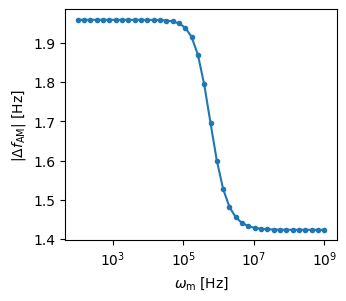

In [17]:
figs['01'] = plotme(omega_m_array, df_array)

::: {.content-hidden when-format="html"}

# Save the figures

In [18]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-61.ipynb && open dissipation-theory--Study-61.html
    
:::